In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from transformers import CamembertForMaskedLM, CamembertTokenizer
from datasets import load_dataset
from tqdm.notebook import tqdm

/home/ben/.switch/dl/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

In [12]:
help('transformers.PreTrainedTokenizer')

Help on class PreTrainedTokenizer in transformers:

transformers.PreTrainedTokenizer = class PreTrainedTokenizer(transformers.tokenization_utils_base.PreTrainedTokenizerBase)
 |  transformers.PreTrainedTokenizer(**kwargs)
 |  
 |  Base class for all slow tokenizers.
 |  
 |  Inherits from :class:`~transformers.tokenization_utils_base.PreTrainedTokenizerBase`.
 |  
 |  Handle all the shared methods for tokenization and special tokens as well as methods downloading/caching/loading
 |  pretrained tokenizers as well as adding tokens to the vocabulary.
 |  
 |  This class also contain the added tokens in a unified way on top of all tokenizers so we don't have to handle the
 |  specific vocabulary augmentation methods of the various underlying dictionary structures (BPE, sentencepiece...).
 |  
 |  Class attributes (overridden by derived classes)
 |  
 |      - **vocab_files_names** (:obj:`Dict[str, str]`) -- A dictionary with, as keys, the ``__init__`` keyword name of
 |        each vocabul

In [13]:
def word_to_tkid(tokenizer, word):
    tks = tokenizer.tokenize(word)
    if len(tks) != 1:
        raise Exception('word_to_tkid')
    return tokenizer.convert_tokens_to_ids(tks[0])

In [14]:
word_to_tkid(tokenizer, 'Bonjour')

1285

In [15]:
tokenizer.convert_ids_to_tokens(tokenizer.encode("Bonjour monde !"))

['<s>', '▁Bonjour', '▁monde', '▁!', '</s>']

In [16]:
tokenizer.decode(tokenizer.encode("Bonjour monde !"))

'<s> Bonjour monde!</s>'

In [8]:
tokenizer.convert_ids_to_tokens(tokenizer.encode("Camembert"))

['<s>', '▁Ca', 'member', 't', '</s>']

In [9]:
def load_confusion(vocab, filename):
    rt = {}
    for i in vocab.values():
        rt[i] = []
    with open(filename, 'r') as f:
        for line in f:
            l = line.split()
            tk0 = int(l[0])
            tk1 = int(l[1])
            d = int(l[2])
            rt[tk0].append((tk1, d))
            rt[tk1].append((tk0, d))
    return rt

In [10]:
confusion = load_confusion(tokenizer.get_vocab(), 'gen/confusion.txt')

In [11]:
def print_confusion(tokenizer, confusion, i):
    c = [(d, j) for (j,d) in confusion[i]]
    c.sort()
    for (d,j) in c:
        print(tokenizer.convert_ids_to_tokens(j), ":", d)

In [12]:
print_confusion(tokenizer, confusion, word_to_tkid(tokenizer, 'Bonjour'))

▁bonjour : 1
▁contour : 2
▁Bonsoir : 2
▁concour : 2
▁Bonheur : 2
▁conjur : 2


In [13]:
def make_correct(tokenizer, confusion, seq):
    count = 0
    for tk in seq:
        if tk in confusion and confusion[tk]:
            count += 1
    count=torch.randint(count, [1]).item()
    for (i,tk) in enumerate(seq):
        if tk in confusion and confusion[tk]:
            count -= 1
            if count < 0:
                masked_seq = seq[:]
                masked_seq[i] = tokenizer.mask_token_id
                return (i, tk, masked_seq)
    raise Exception('make_error')

In [14]:
i,tk,seq = make_correct(tokenizer, confusion, tokenizer.encode('Bonjour monde !'))
i,tk,tokenizer.decode(seq)

(2, 164, '<s> Bonjour<mask>!</s>')

In [15]:
confusion_prob = [0, 1, 0.2]
def make_error(tokenizer, confusion, seq):
    s = 0
    for tk in seq:
        if tk not in confusion:
            continue
        for _,d in confusion[tk]:
            s += confusion_prob[d]
    s *= torch.rand(1).item()
    for (i,tk) in enumerate(seq):
        if tk not in confusion:
            continue
        for rep,d in confusion[tk]:
            s -= confusion_prob[d]
            if s < 0:
                masked_seq = seq[:]
                masked_seq[i] = tokenizer.mask_token_id
                return (i, tk, rep, masked_seq)
    raise Exception('make_error')

In [16]:
i,tk,rep,seq = make_error(tokenizer, confusion, tokenizer.encode('Bonjour monde !'))
i,tk,rep,tokenizer.decode(seq)

(3, 83, 6777, '<s> Bonjour monde<mask></s>')

In [17]:
# return [o[index[i]] for o in out]
def index2(src, index):
    flat_index = src.shape[1] * torch.tensor(range(src.shape[0])) + index
    return torch.flatten(src,start_dim=0, end_dim=1)[flat_index]

In [18]:
src = torch.tensor([[1,2,3,4], [5,6,7,8], [9,10,11, 12]])
trg = torch.tensor([0, 1, 1])
index2(src, trg)

tensor([ 1,  6, 10])

In [19]:
class MaskedProb(nn.Module):
    def __init__(self, transformer):
        super(MaskedProb, self).__init__()
        self.transformer = transformer

    def forward(self, index, tk, input_ids, attention_mask=None):
        out = self.transformer(input_ids, attention_mask=attention_mask)[0]
        out_index = index2(out, index)
        out_token = index2(out_index, tk)
        return out_token

In [20]:
mmodel = MaskedProb(CamembertForMaskedLM.from_pretrained("camembert-base"))
mmodel.eval()

Some weights of CamembertForMaskedLM were not initialized from the model checkpoint at camembert-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MaskedProb(
  (transformer): CamembertForMaskedLM(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(32005, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_feature

In [21]:
def make_correct_set(tokenizer, confusion, src_seqs, sample_per_seq=1):
    indexes = []
    tokens  = []
    seqs    = []
    for src_seq in src_seqs:
        for _ in range(sample_per_seq):
            i,tk,seq = make_correct(tokenizer, confusion, src_seq)
            indexes.append(i)
            tokens.append(tk)
            seqs.append(seq)
    return torch.tensor(indexes),torch.tensor(tokens),torch.tensor(seqs)

In [22]:
def make_error_set(tokenizer, confusion, src_seqs, sample_per_seq=1):
    indexes = []
    tokens  = []
    seqs    = []
    for src_seq in src_seqs:
        for _ in range(sample_per_seq):
            i,_,tk,seq = make_error(tokenizer, confusion, src_seq)
            indexes.append(i)
            tokens.append(tk)
            seqs.append(seq)
    return torch.tensor(indexes),torch.tensor(tokens),torch.tensor(seqs)

In [23]:
tokenizer.mask_token_id

32004

In [24]:
make_correct_set(tokenizer, confusion, [tokenizer.encode('Bonjour monde !')], sample_per_seq=5)

(tensor([2, 1, 1, 1, 1]),
 tensor([ 164, 1285, 1285, 1285, 1285]),
 tensor([[    5,  1285, 32004,    83,     6],
         [    5, 32004,   164,    83,     6],
         [    5, 32004,   164,    83,     6],
         [    5, 32004,   164,    83,     6],
         [    5, 32004,   164,    83,     6]]))

In [25]:
mmodel(*make_correct_set(tokenizer, confusion, [tokenizer.encode('Bonjour monde !')], sample_per_seq=5))

tensor([ 4.6110, 12.6879, 12.6879,  4.6110,  4.6110], grad_fn=<IndexBackward>)

In [26]:
mmodel(*make_error_set(tokenizer, confusion, [tokenizer.encode('Bonjour monde !')], sample_per_seq=5))

tensor([-1.8936,  2.0456,  4.7844,  3.7671,  3.6979], grad_fn=<IndexBackward>)

-----------------------------

In [3]:
src_dataset = load_dataset("allocine")

Reusing dataset allocine_dataset (/home/ben/.cache/huggingface/datasets/allocine_dataset/allocine/1.0.0/bbee2ebb45a067891973b91ebdd40a93598d1e2dd5710b6714cdc2cd81d0ed65)


In [4]:
src_dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 160000
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
})

In [ ]:
src_dataset = src_dataset['test'].select(range(30))

In [43]:
src_dataset

Dataset({
    features: ['review', 'label'],
    num_rows: 30
})

In [44]:
tkn_dataset = src_dataset.map(
    lambda x: tokenizer(x['review'], truncation=True, padding='max_length', max_length=50),
    batched=True)
del src_dataset

Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/allocine_dataset/allocine/1.0.0/bbee2ebb45a067891973b91ebdd40a93598d1e2dd5710b6714cdc2cd81d0ed65/cache-09a92c40fb180311.arrow


In [45]:
tkn_dataset

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'review'],
    num_rows: 30
})

In [47]:
def load_correct_data(src):
    indexes = []
    tokens  = []
    seqs    = []
    for src_seq in src['input_ids']:
        i,tk,seq = make_correct(tokenizer, confusion, src_seq)
        indexes.append(i)
        tokens.append(tk)
        seqs.append(seq)
    return {'index': indexes, 'token':tokens, 'input_ids':seqs}

def load_error_data(src):
    indexes = []
    tokens  = []
    seqs    = []
    for src_seq in src['input_ids']:
        i,_,tk,seq = make_error(tokenizer, confusion, src_seq)
        indexes.append(i)
        tokens.append(tk)
        seqs.append(seq)
    return {'index': indexes, 'token':tokens, 'input_ids':seqs}

In [48]:
correct_data = tkn_dataset.map(load_correct_data, batched=True, batch_size=1)
error_data = tkn_dataset.map(load_error_data, batched=True, batch_size=1)

Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/allocine_dataset/allocine/1.0.0/bbee2ebb45a067891973b91ebdd40a93598d1e2dd5710b6714cdc2cd81d0ed65/cache-95df08c2333242f9.arrow


In [49]:
correct_data

Dataset({
    features: ['attention_mask', 'index', 'input_ids', 'label', 'review', 'token'],
    num_rows: 30
})

In [50]:
correct_data.set_format(type='torch', columns=['index', 'token', 'input_ids', 'attention_mask'])
error_data.set_format(type='torch', columns=['index', 'token', 'input_ids', 'attention_mask'])

In [51]:
def compute_out(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
    outputs = []
    for batch in tqdm(dataloader):
        out = mmodel(batch['index'], batch['token'], batch['input_ids'], batch['attention_mask'])
        outputs.append(out)
    return torch.cat(outputs)

In [52]:
correct_out = compute_out(correct_data)
error_out = compute_out(error_data)

In [53]:
correct_out.mean(), error_out.mean()

(tensor(12.9061, grad_fn=<MeanBackward0>),
 tensor(-0.3260, grad_fn=<MeanBackward0>))

In [8]:
# saved values
correct_out = torch.tensor([ 8.0803, 14.0775, 20.3621, 20.1007,  1.8873, 16.6029, 17.8609, 20.0898,
        20.7961,  4.7384, 14.6751, 13.5050, 21.4819, 12.9984,  3.6142,  3.6772,
        15.0367, 17.9873,  9.6927, 17.9419,  4.8643, 14.4097, -1.7783, 16.8282,
         5.7749, 13.0285, 10.2834, 18.6509, 22.5966,  7.3192])
error_out = torch.tensor([ 2.7671, -5.2592,  3.5916,  1.6725,  4.0862, -3.8351, -6.8906, -0.1720,
        -0.1972, -4.6426, -0.1949, -4.0336, -2.6897, -4.3467, -1.9231,  0.8093,
         0.9162, -0.2468,  1.1669, -4.0763, 12.1963,  0.1935,  0.7147, -0.7231,
         1.4321,  1.5579, -0.5683,  8.0869, -4.6107, -4.5620])

In [9]:
def cumulated(vs):
    xs = np.sort(vs)
    ys = np.array(range(1,len(vs)+1)) / len(vs)
    return xs,ys

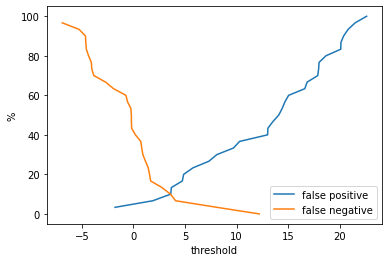

In [10]:
ccx,ccy = cumulated(correct_out.detach().numpy())
ecx,ecy = cumulated(error_out.detach().numpy())
ccy = 100 * ccy       # false positive
ecy = 100 * (1 - ecy) # false negative
plt.plot(ccx, ccy, label='false positive')
plt.plot(ecx, ecy, label='false negative')
plt.xlabel('threshold')
plt.ylabel('%')
plt.legend()
plt.show()

------------------

In [36]:
def fill_mask(masked_input, model, tokenizer, topk=5, input_word=None):
    # Adapted from https://github.com/pytorch/fairseq/blob/master/fairseq/models/roberta/hub_interface.py
    assert masked_input.count("<mask>") == 1
    input_ids = torch.tensor(tokenizer.encode(masked_input, add_special_tokens=True)).unsqueeze(0)  # Batch size 1
    output = model(input_ids)
    logits = output[0]  # The last hidden-state is the first element of the output tuple
    masked_index = (input_ids.squeeze() == tokenizer.mask_token_id).nonzero(as_tuple=False).item()
    logits = logits[0, masked_index, :]
    prob = logits.softmax(dim=0)
    
    if input_word:
        iw_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(input_word)[0])
        print('iw logit: {:.3f}'.format(logits[iw_id]))
    
    values, indices = prob.topk(k=topk, dim=0)
    topk_predicted_token_bpe = " ".join(
        [tokenizer.convert_ids_to_tokens(indices[i].item()) for i in range(len(indices))]
    )
    masked_token = tokenizer.mask_token
    topk_filled_outputs = []
    for index, predicted_token_bpe in enumerate(topk_predicted_token_bpe.split(" ")):
        predicted_token = predicted_token_bpe.replace("\u2581", " ")
        if " {0}".format(masked_token) in masked_input:
            topk_filled_outputs.append(
                (
                    masked_input.replace(" {0}".format(masked_token), predicted_token),
                    values[index].item(),
                    predicted_token,
                )
            )
        else:
            topk_filled_outputs.append(
                (masked_input.replace(masked_token, predicted_token), values[index].item(), predicted_token,)
            )
    return topk_filled_outputs

In [47]:
masked_input = "Le camembert est <mask>"
print(fill_mask(masked_input, model, tokenizer, input_word='servi'))

iw logit: 5.593
[('Le camembert est un', 0.3286605477333069, ' un'), ('Le camembert est ...', 0.182983860373497, ' ...'), ('Le camembert est une', 0.11833460628986359, ' une'), ('Le camembert est [...]', 0.10589182376861572, ' [...]'), ('Le camembert est le', 0.046711746603250504, ' le')]
